# 30-day Hospital readmission risk prediction

## 1. Overview

In this capstone project, the goal is to compare the performance of several machine learning classifiers—K-Nearest Neighbors, Logistic Regression, and Decision Trees—in predicting unplanned 30-day hospital readmission among diabetic patients. The analysis uses patient demographic, clinical, and treatment data available at discharge to build an interpretable and clinically relevant risk prediction model that can support post-discharge care planning and readmission prevention.  

## 2. Setup and Imports

In this section, we import all the Python libraries we need for the analysis.


In [27]:
# Imports, Global Warning Suppression, Load Dataset

import warnings
# Global Warning Suppression
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Global plot style
sns.set(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 11

# Avoid long auto-printed outputs
pd.set_option("display.max_rows", 30)

# Retain the ability to see all the attributes of the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

RANDOM_STATE = 42

In [28]:
# Uncomment for execution using Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

## 3. Data Loading and Initial Inspection

We start by loading the dataset `hospital_readmission_risk.csv` from the data directory.

We will:

- Load the CSV into a pandas DataFrame  
- Inspect the first few rows  
- Check the data types and basic statistics  


The below information was extracted from https://www.kaggle.com/datasets/dubradave/hospital-readmissions/data:

*   "age" - age bracket of the patient
*   "time_in_hospital" - days (from 1 to 14)
*   "n_procedures" - number of procedures performed during the hospital stay   
*   "n_lab_procedures" - number of laboratory procedures performed during the hospital stay
*   "n_medications" - number of medications administered during the hospital stay
*   "n_outpatient" - number of outpatient visits in the year before a hospital stay
*   "n_inpatient" - number of inpatient visits in the year before the hospital stay
*   "n_emergency" - number of visits to the emergency room in the year before the hospital stay
*   "medical_specialty" - the specialty of the admitting physician
*   "diag_1" - primary diagnosis (Circulatory, Respiratory, Digestive, etc.)
*   "diag_2" - secondary diagnosis
*   "diag_3" - additional secondary diagnosis
*   "glucose_test" - whether the glucose serum came out as high (> 200), normal, or not performed
*   "A1Ctest" - whether the A1C level of the patient came out as high (> 7%), normal, or not performed
*   "change" - whether there was a change in the diabetes medication ('yes' or 'no')
*   "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')
*   "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no')

In [29]:
# Load the dataset
# Uncomment for execution using Google Colab
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CapStone Project/data/hospital_readmissions.csv')
df = pd.read_csv('data/hospital_readmissions.csv')

# Show first few rows
df.head()

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


In [30]:
print("Rows:", df.shape[0], "Columns:", df.shape[1])
# Basic info about the dataset
df.info()

Rows: 25000 Columns: 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted      

Now, we know which columns are numeric and which are categorical:

Numeric columns:

*   "time_in_hospital" - days (from 1 to 14)
*   "n_procedures" - number of procedures performed during the hospital stay   
*   "n_lab_procedures" - number of laboratory procedures performed during the hospital stay
*   "n_medications" - number of medications administered during the hospital stay
*   "n_outpatient" - number of outpatient visits in the year before a hospital stay
*   "n_inpatient" - number of inpatient visits in the year before the hospital stay
*   "n_emergency" - number of visits to the emergency room in the year before the hospital stay

Categorical columns:

*   "age" - age bracket of the patient
*   "medical_specialty" - the specialty of the admitting physician
*   "diag_1" - primary diagnosis (Circulatory, Respiratory, Digestive, etc.)
*   "diag_2" - secondary diagnosis
*   "diag_3" - additional secondary diagnosis
*   "glucose_test" - whether the glucose serum came out as high (> 200), normal, or not performed
*   "A1Ctest" - whether the A1C level of the patient came out as high (> 7%), normal, or not performed
*   "change" - whether there was a change in the diabetes medication ('yes' or 'no')
*   "diabetes_med" - whether a diabetes medication was prescribed ('yes' or 'no')
*   "readmitted" - if the patient was readmitted at the hospital ('yes' or 'no')

We also know that we have 25,000 rows and 17 columns in this dataset.

In [31]:
# Summary statistics for numeric and categorical columns
df.describe(include="all")

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
count,25000,25000.00000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000,25000,25000,25000,25000,25000,25000,25000,25000
unique,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,8,8,8,3,3,2,2,2
top,[70-80),NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,Circulatory,Other,Other,no,no,no,yes,no
freq,6837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12382,7824,9056,9107,23625,20938,13497,19228,13246
mean,NaN,4.45332,43.24076,1.352360,16.252400,0.366400,0.615960,0.186600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,3.00147,19.81862,1.715179,8.060532,1.195478,1.177951,0.885873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.00000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.00000,31.00000,0.000000,11.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,4.00000,44.00000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,6.00000,57.00000,2.000000,20.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are 25,000 patients in the dataset. There are no missing values (note how all the columns show a count of 25,000). There is a mix of numerical (encounter-level features) and categorical (demographics, diagnoses, tests and medications).

**Demographics:**

*age:*

Further, there are 6 age groups with the most common being [70-80) (6,837 patients = ~ 27%). The dataset is skewed towards older population (this is expected, especially in Type 2 Diabetes). Older patients seem to be likely higher readmission risk.

**Hospital Utilization:**

*time_in_hospital:*

Range: 1-14 days with mean being 4.45 and median = 4 indicate a moderate right skew (some longer stays).

**Medication and Visit history:**

*n_medications:*

Mean: ~16 medications, Range: 1-79. There is an indication of polypharmacy (https://www.ncbi.nlm.nih.gov/books/NBK532953/. This is a strong potential predictor for readmission.

**Prior Utilization:**

*n_outpatient:*

Most had no outpatient visits (Mean: ~0.37).

*n_inpatient:*

We see some prior hospitalizations (Mean: ~0.62).

*n_emergency:*

We see few extreme outliers (Max: 64).

These are strong readmission predictors.

**Clinical Features:**

*medical_specialty:*

There are 7 categories with the most common being "Missing" (12,382 = ~49%).

*diag_1:*

There are 8 categories in Primary diagnosis with the most common being "Circulatory" (7,824 = ~31%). This is common for diabetes population.

*Lab Tests: glucose_test and A1Ctest:*

The most common value for Glucose Test is "no" which is about 94% (23,625) and the most common value for A1C Test is "no" which is about 84% (20,938). Most patients did not receive either tests during stay.

**Diabetes Treatment:**

There are 2 categories for change in medication with "no" being the slightly more common value.

About 77% (19,228) patients were prescribed with diabetes medication.

**Target Variable:**

About 53% (13,246) of patients were not readmitted while about 47%

## 4. Exploratory Data Analysis (EDA)

The goal of EDA is to understand:

- What features are available and how they are distributed  
- Whether there are obvious outliers or anomalies  
- How the different variables relate to each other  

We will:

- Analyze missing values
- Visualize distributions of key numeric variables  
- Explore categorical variables  
- Inspect relationships between potential clustering features  


### 4.1 Missing Values Analysis

In [32]:
# Investigate the dataset for missing or problematic data

missing_counts = df.isnull().sum()
missing_percentages = (df.isnull().sum() / len(df)) * 100
print("Missing Value Counts:\n", missing_counts)
print("\nMissing Value Percentages:\n", missing_percentages)

Missing Value Counts:
 age                  0
time_in_hospital     0
n_lab_procedures     0
n_procedures         0
n_medications        0
n_outpatient         0
n_inpatient          0
n_emergency          0
medical_specialty    0
diag_1               0
diag_2               0
diag_3               0
glucose_test         0
A1Ctest              0
change               0
diabetes_med         0
readmitted           0
dtype: int64

Missing Value Percentages:
 age                  0.0
time_in_hospital     0.0
n_lab_procedures     0.0
n_procedures         0.0
n_medications        0.0
n_outpatient         0.0
n_inpatient          0.0
n_emergency          0.0
medical_specialty    0.0
diag_1               0.0
diag_2               0.0
diag_3               0.0
glucose_test         0.0
A1Ctest              0.0
change               0.0
diabetes_med         0.0
readmitted           0.0
dtype: float64


There are no blank or null values in the dataset.

### 4.2 Target Variable Distribution

The target column from this dataset is *readmitted*.



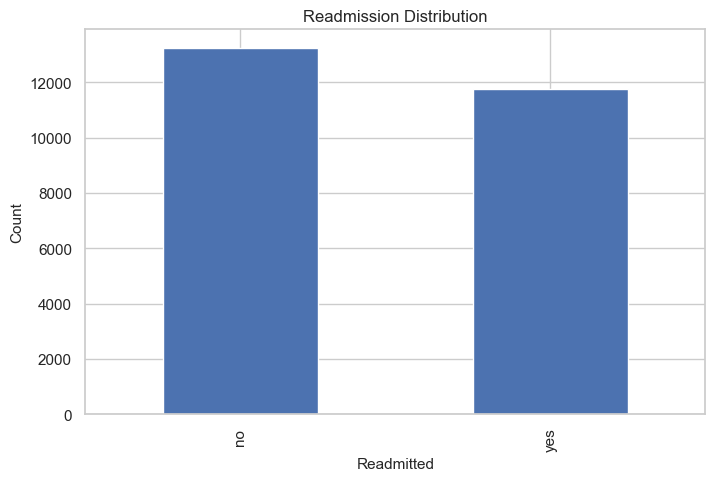

In [33]:
df['readmitted'].value_counts()

plt.figure()
df['readmitted'].value_counts().plot(kind='bar')
plt.title("Readmission Distribution")
plt.xlabel("Readmitted")
plt.ylabel("Count")
plt.show()

In [34]:
# Getting readmission counts and checking imbalance

readmission_counts = df['readmitted'].value_counts()

not_readmitted = readmission_counts['no']
readmitted = readmission_counts['yes']

print(f"No readmissions: {not_readmitted:,}")
print(f"Readmitted: {readmitted:,} \n")

df['readmitted'].value_counts(normalize=True) * 100


No readmissions: 13,246
Readmitted: 11,754 



readmitted
no     52.984
yes    47.016
Name: proportion, dtype: float64

The dataset is fairly balanced with 11,754 readmissions (47%) and is good for modeling.

### 4.3 Numerical Feature Analysis

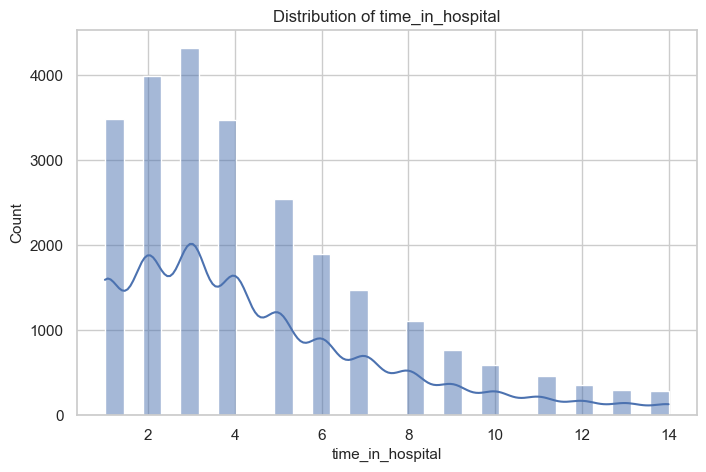

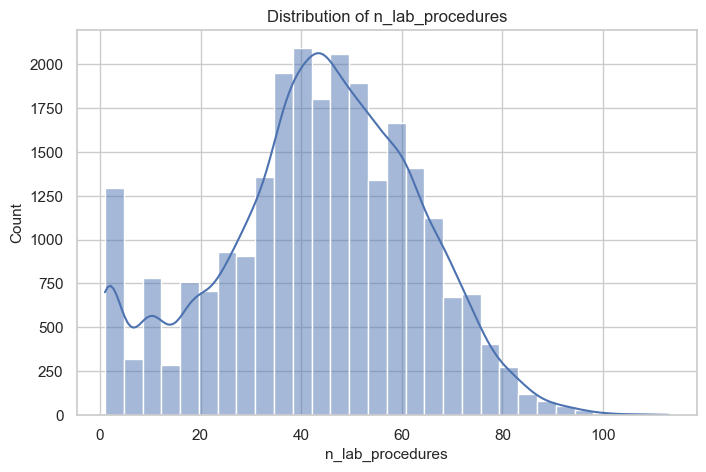

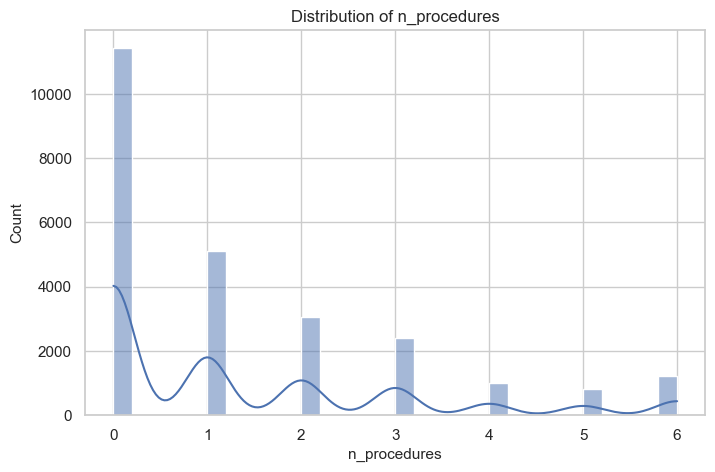

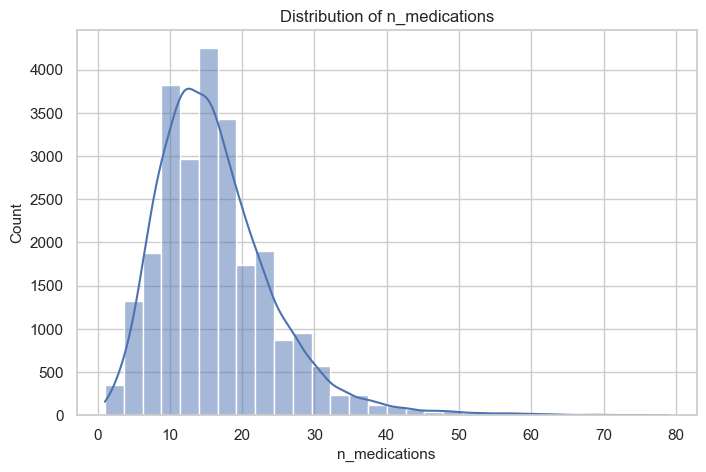

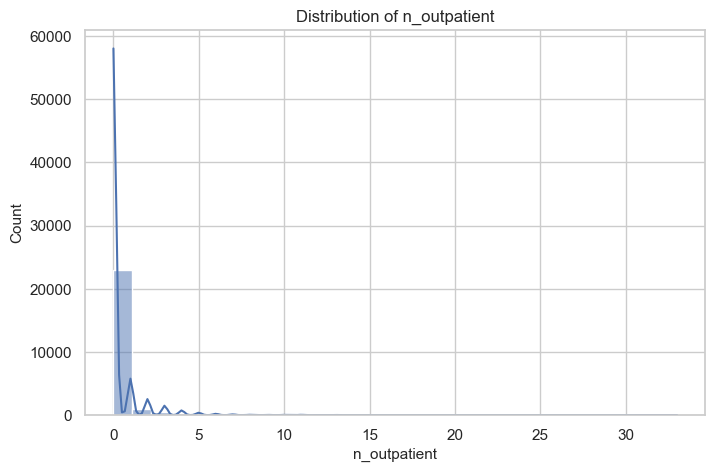

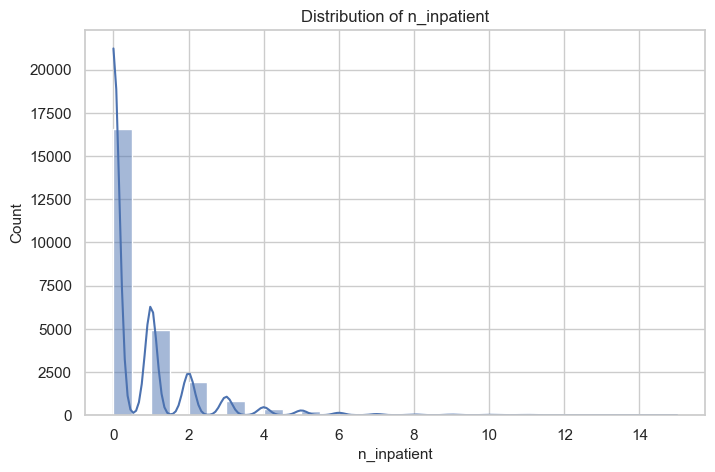

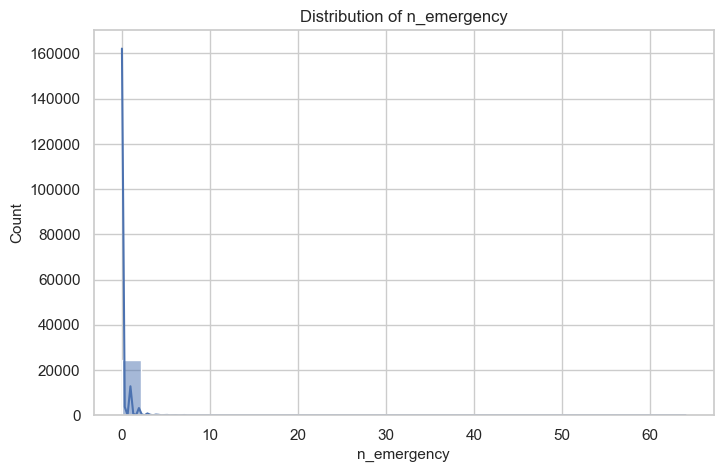

In [35]:
numerical_cols = df.select_dtypes(include=['int64']).columns

for col in numerical_cols:
    plt.figure()
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


Numerical features reveal substantial variability in length of stay, healthcare utilization, and medication burden. Utilization variables are heavily right-skewed with a small group of high utilizers, while medication and lab counts indicate varying levels of clinical complexity. These patterns highlight strong predictive potential but require preprocessing to handle skewness and outliers.

### 4.4 Categorical Feature Analysis

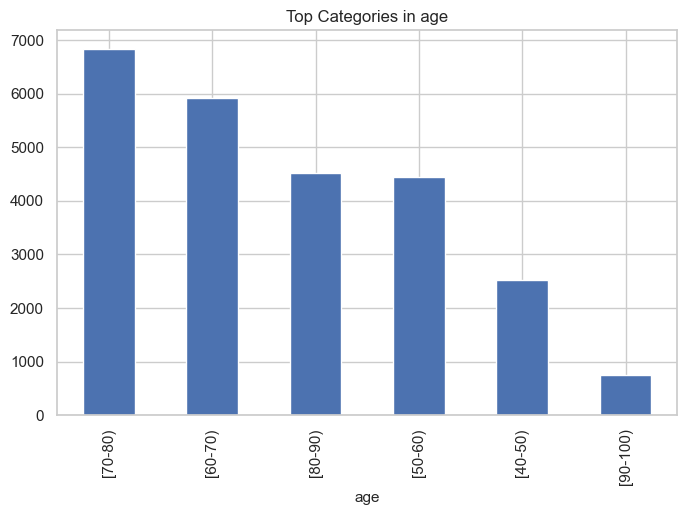

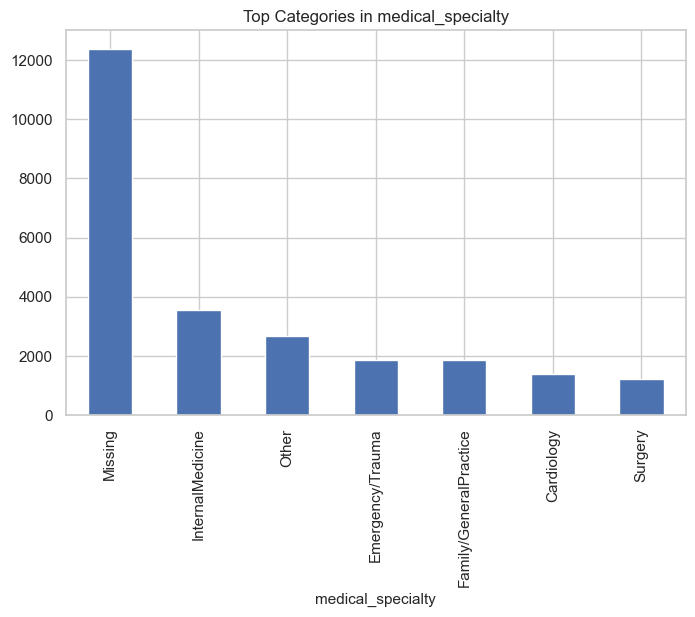

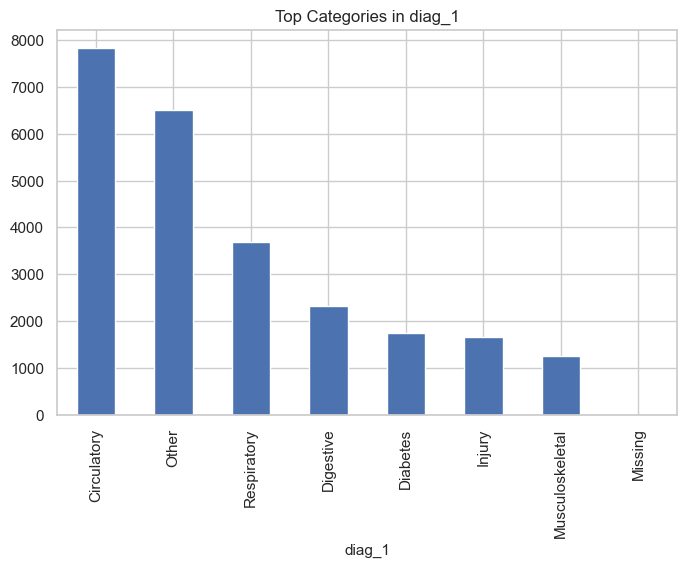

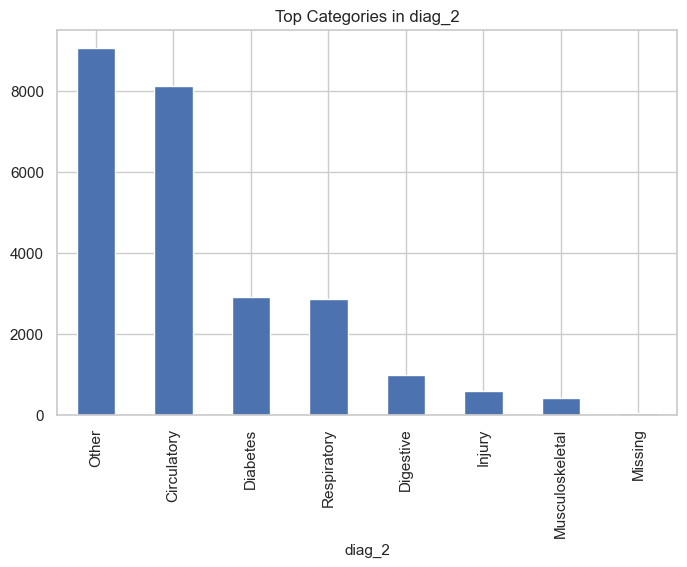

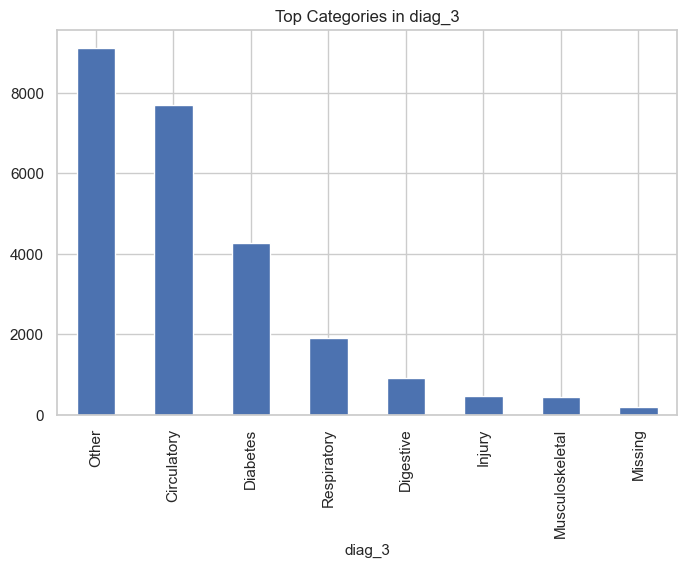

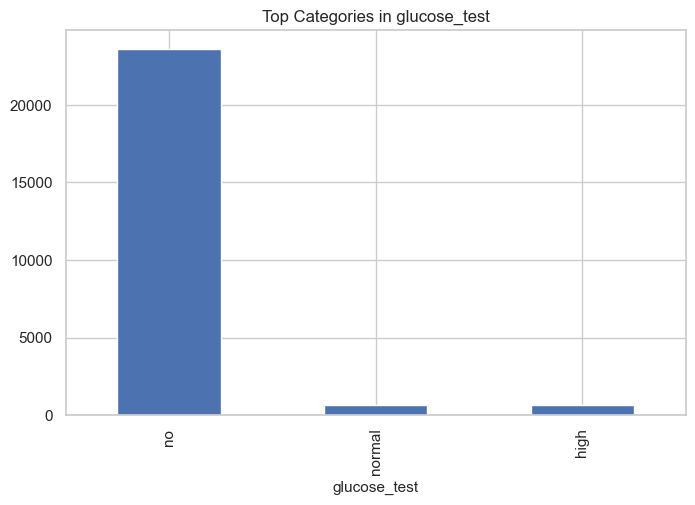

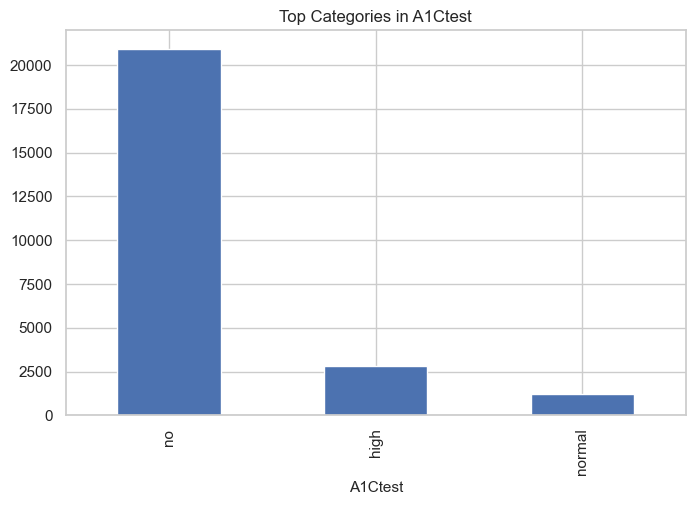

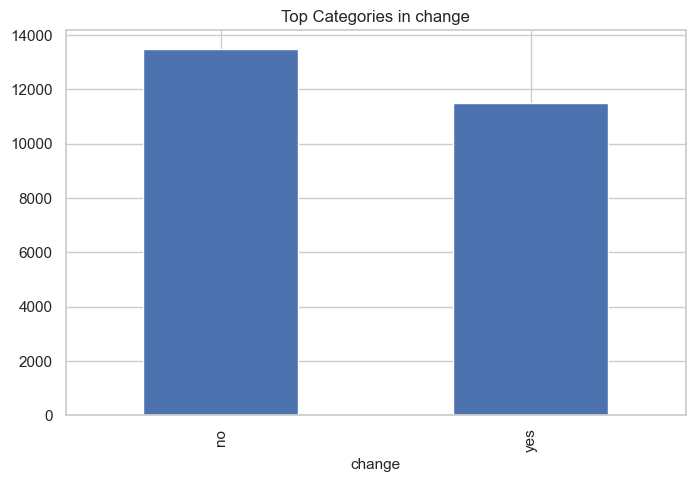

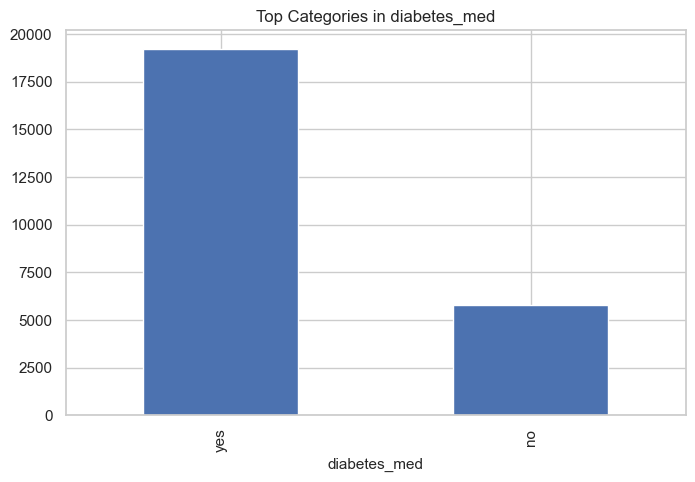

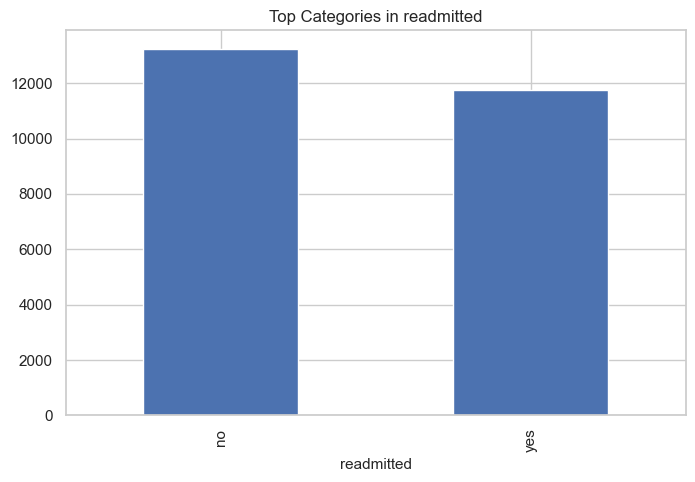

In [36]:
categorical_cols = df.select_dtypes(include='object').columns

for col in categorical_cols:
    plt.figure()
    df[col].value_counts().head(10).plot(kind='bar')
    plt.title(f'Top Categories in {col}')
    plt.show()


Categorical features highlight an elderly diabetic population with common circulatory diagnoses and substantial variability in testing and treatment practices. Several variables contain large “Unknown” categories, reflecting documentation or workflow differences that must be addressed during preprocessing. These features offer clinically interpretable signals relevant to readmission risk and care delivery patterns.

### 4.5 Correlation Analysis (Numerical)

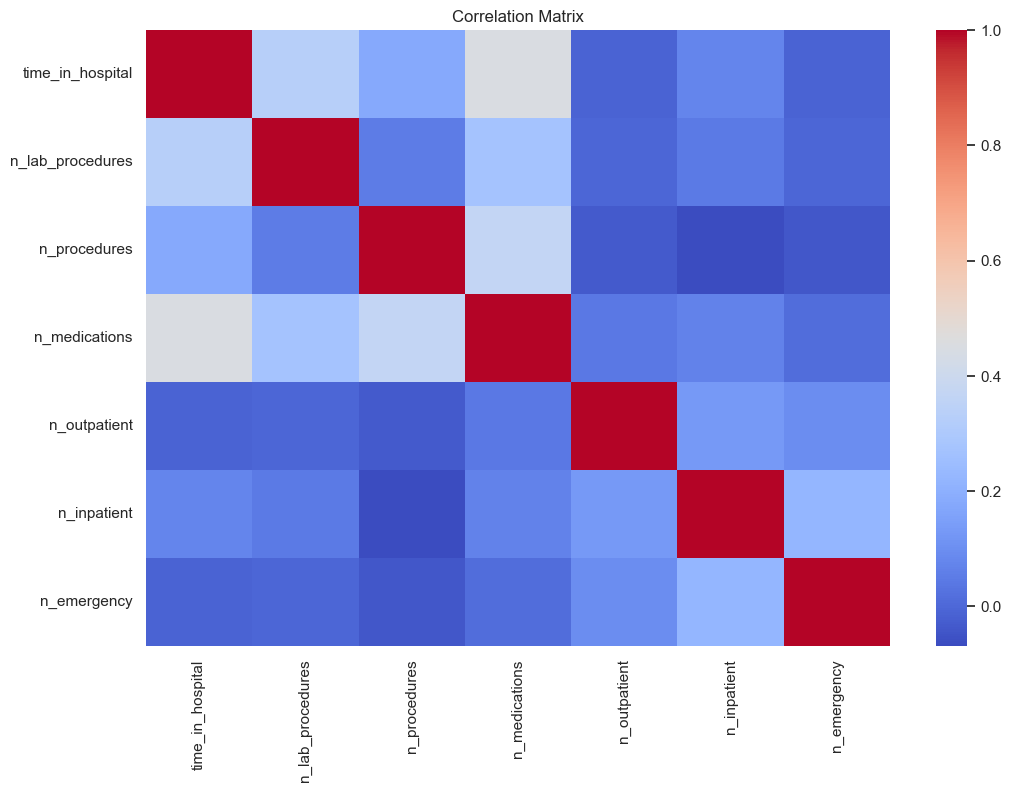

In [37]:
plt.figure(figsize=(12,8))
sns.heatmap(df[numerical_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()


Numerical correlation analysis showed moderate associations among utilization and care-intensity variables, such as length of stay (time_in_hospital), medication counts, and lab procedures. No strong multicollinearity was observed, indicating that these features can be used together effectively in predictive models.

### 4.6 Relationship with Target

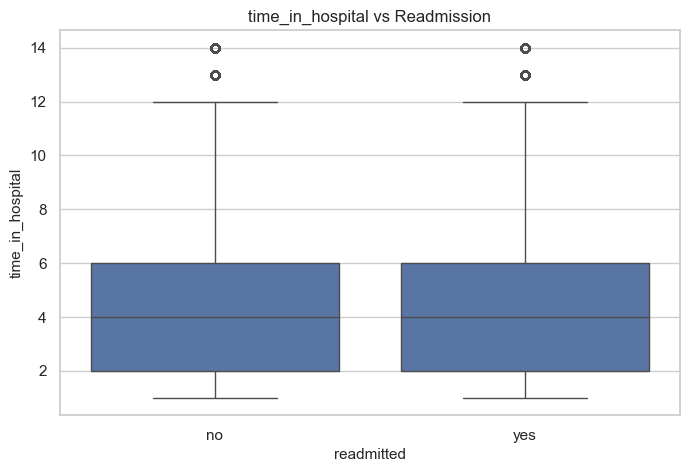

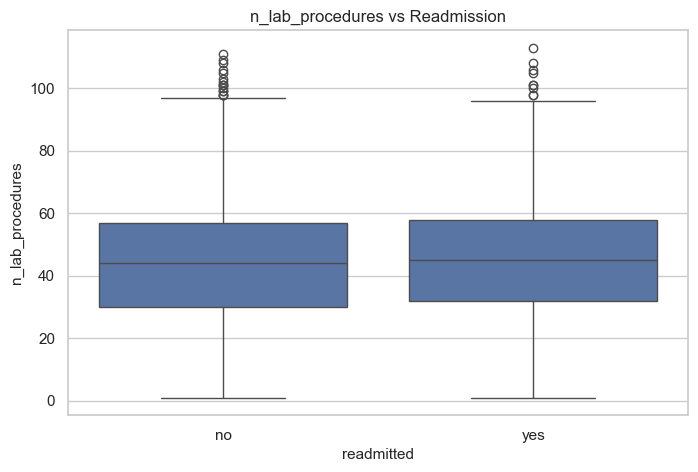

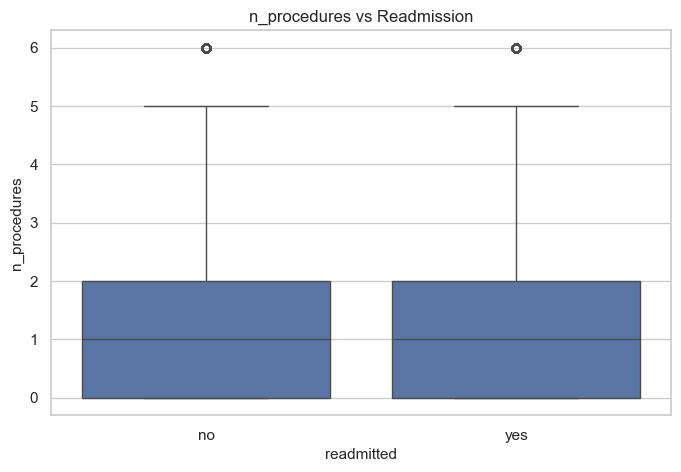

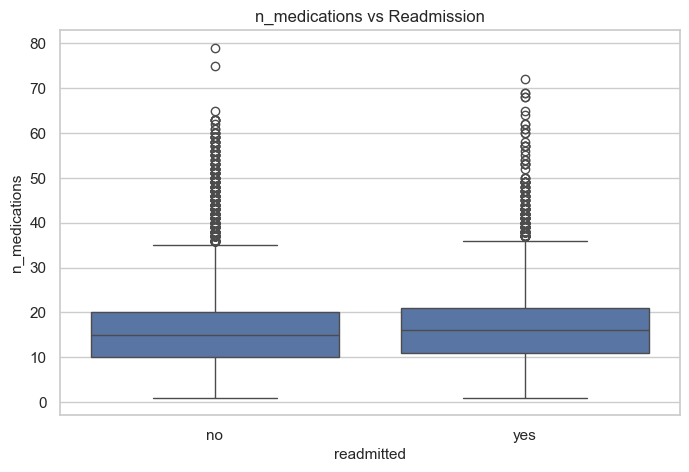

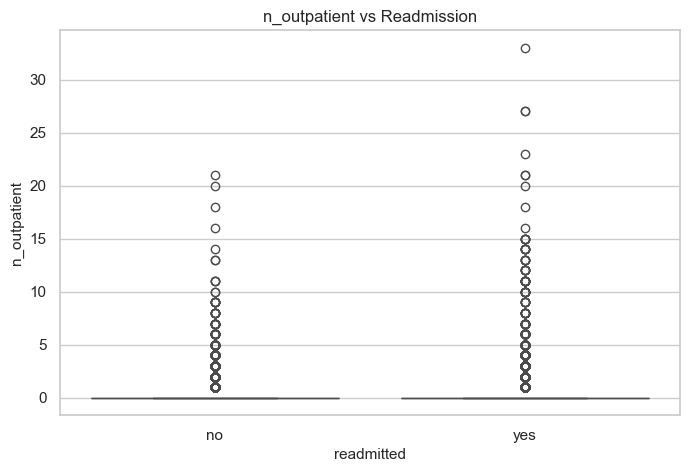

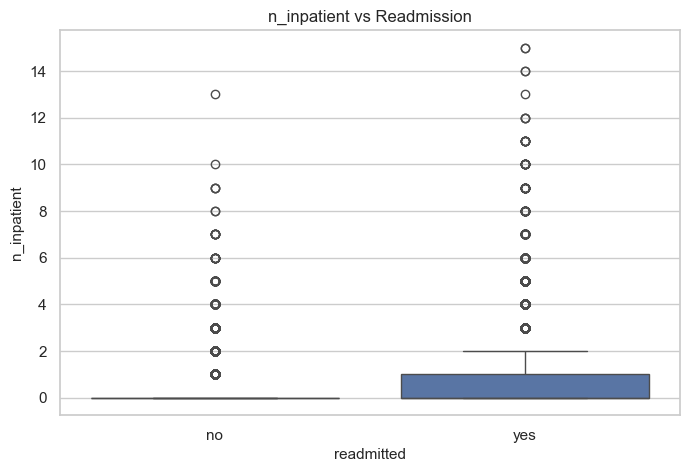

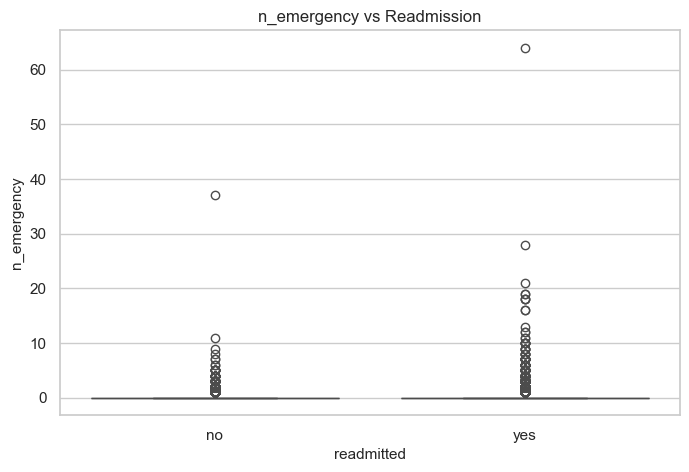

In [38]:
# Numerical vs Target
for col in numerical_cols:
    plt.figure()
    sns.boxplot(x='readmitted', y=col, data=df)
    plt.title(f'{col} vs Readmission')
    plt.show()


Readmitted patients show higher utilization and clinical complexity, including longer stays, more prior visits, and greater medication burden, highlighting these numerical features as key predictors of readmission risk.

<Figure size 800x500 with 0 Axes>

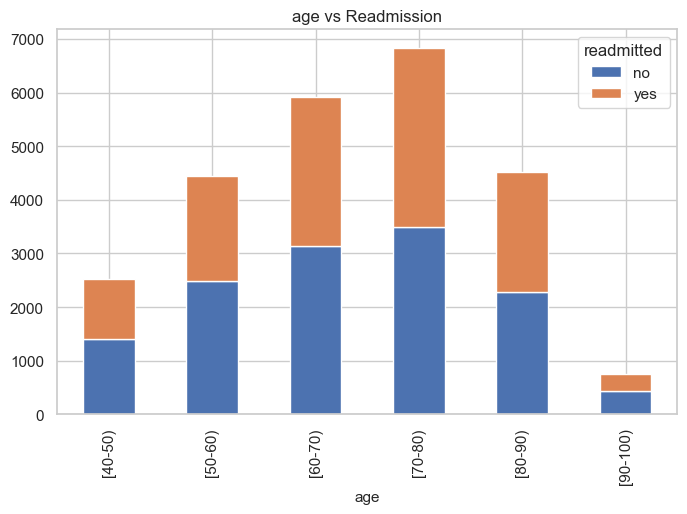

<Figure size 800x500 with 0 Axes>

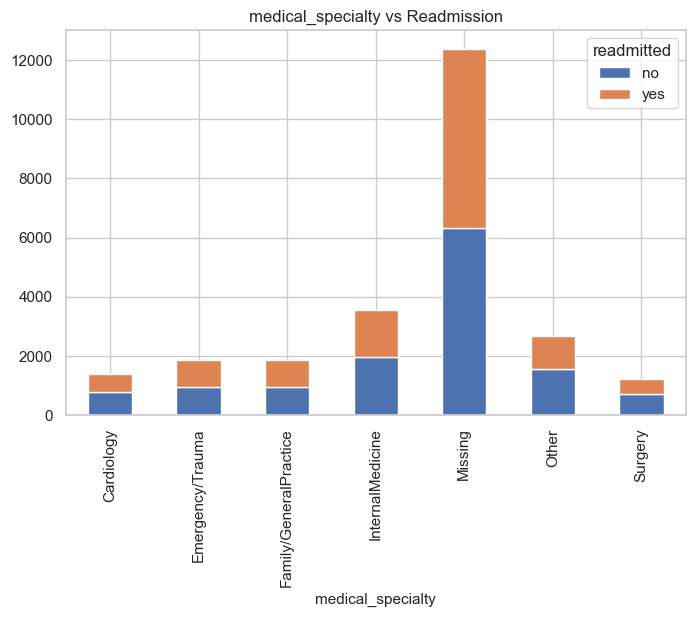

<Figure size 800x500 with 0 Axes>

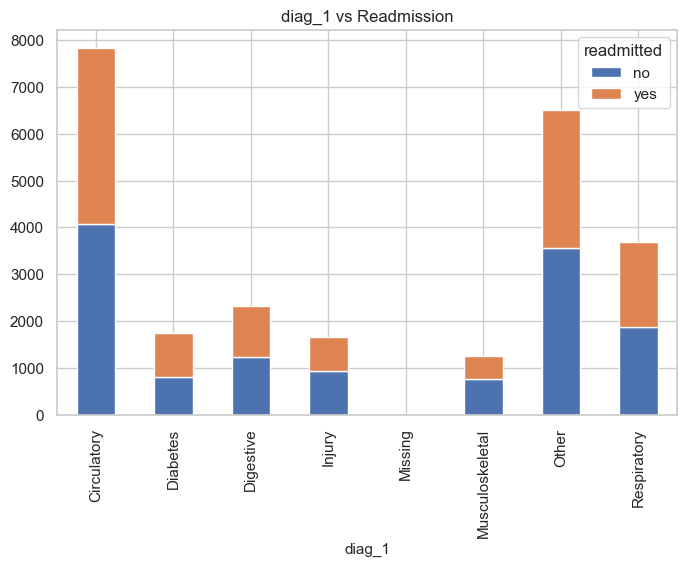

<Figure size 800x500 with 0 Axes>

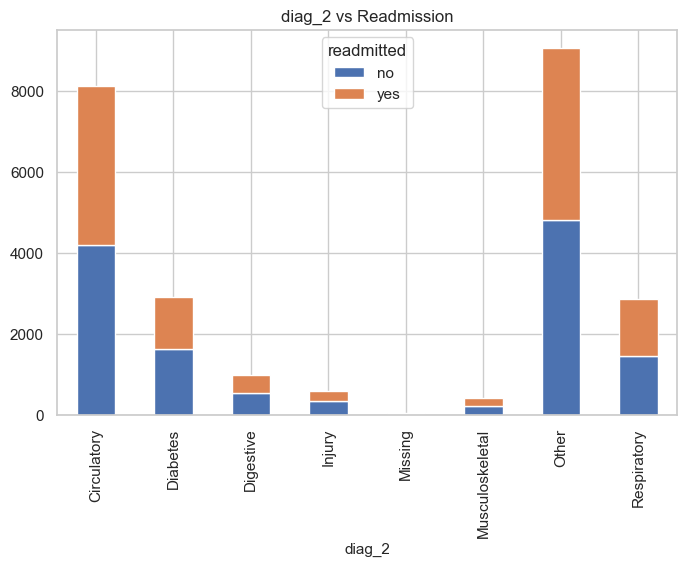

<Figure size 800x500 with 0 Axes>

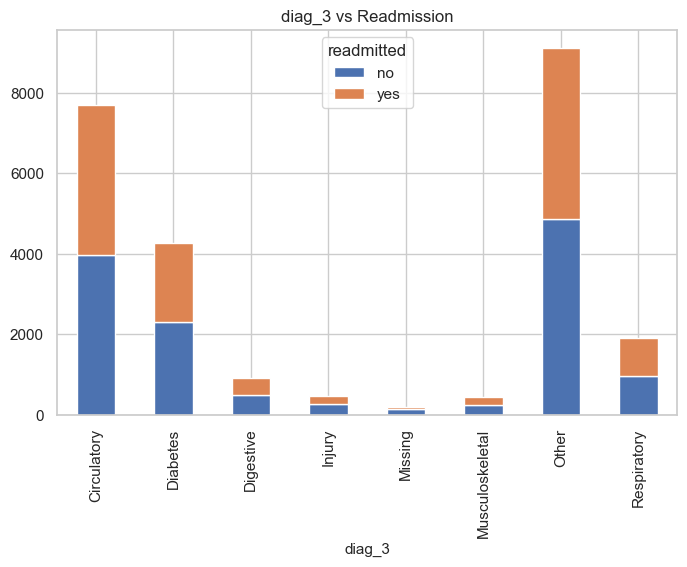

<Figure size 800x500 with 0 Axes>

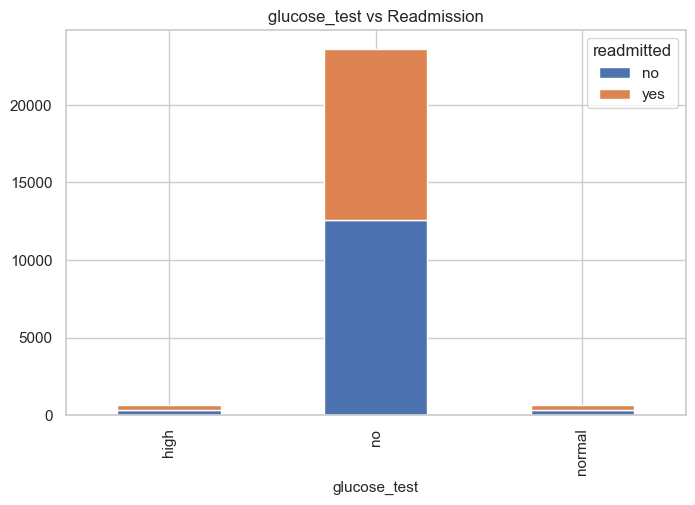

<Figure size 800x500 with 0 Axes>

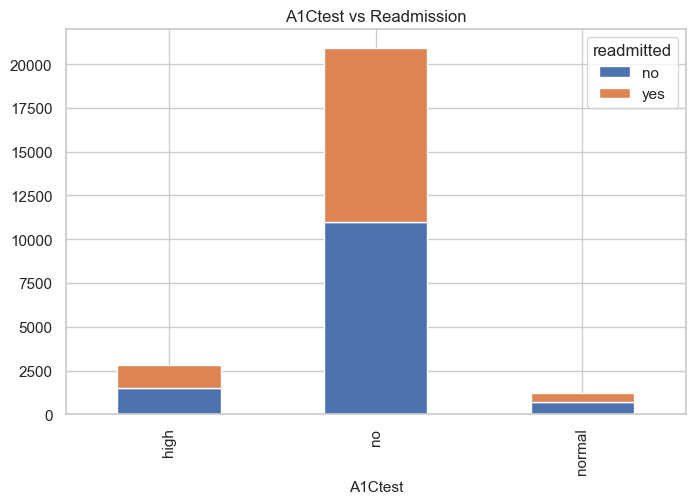

<Figure size 800x500 with 0 Axes>

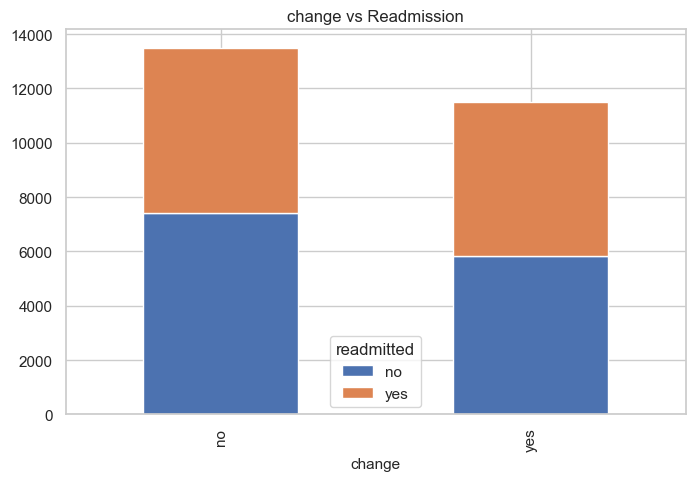

<Figure size 800x500 with 0 Axes>

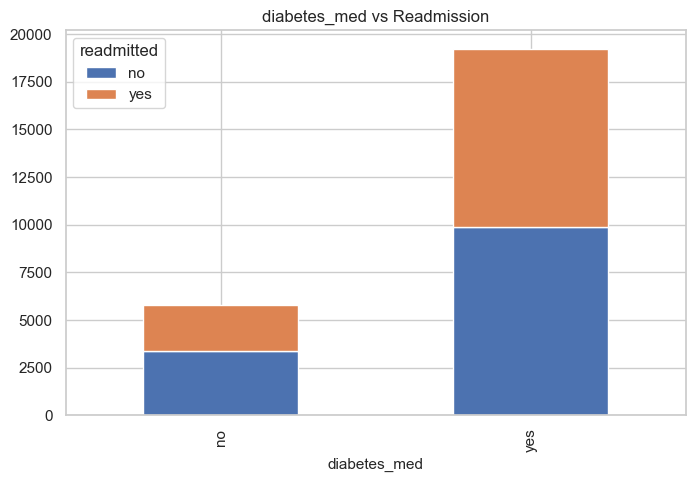

<Figure size 800x500 with 0 Axes>

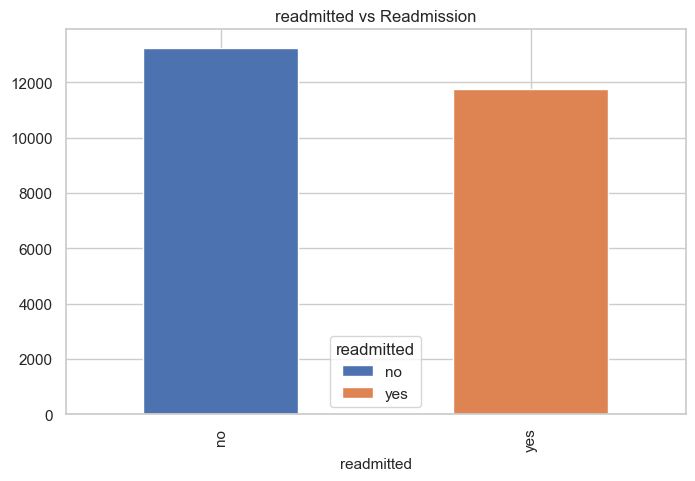

In [39]:
# Categorical vs Target
for col in categorical_cols:
    plt.figure()
    pd.crosstab(df[col], df['readmitted']).plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Readmission')
    plt.show()


Readmission rates differ across age groups, diagnosis categories, and treatment patterns, with higher risk observed among older patients, certain diagnostic groups, and those requiring medication changes, underscoring the predictive value of categorical features.

### 4.7 Outlier Detection

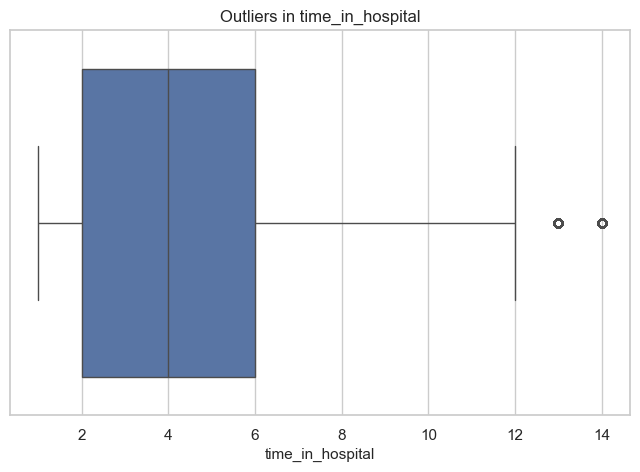

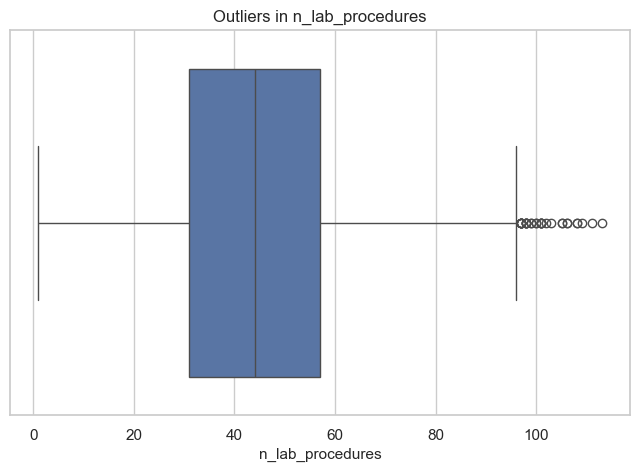

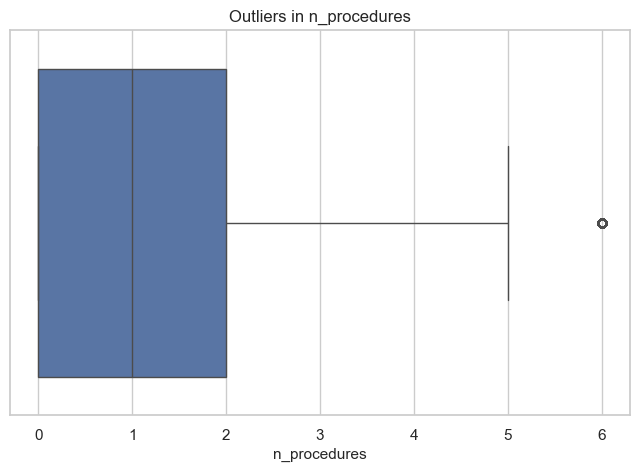

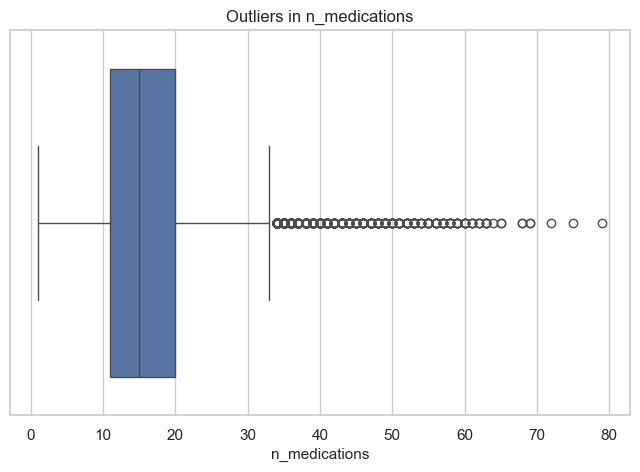

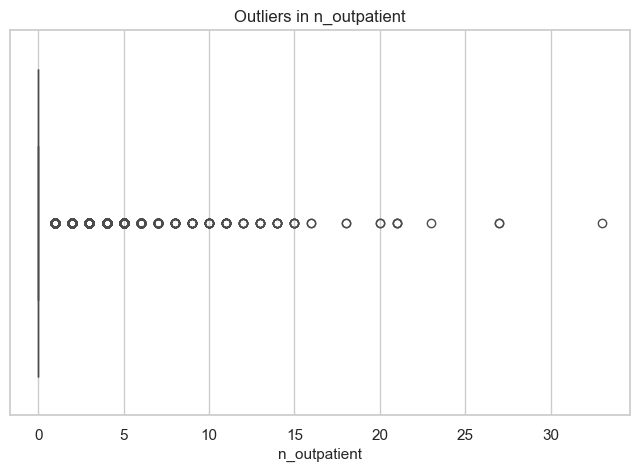

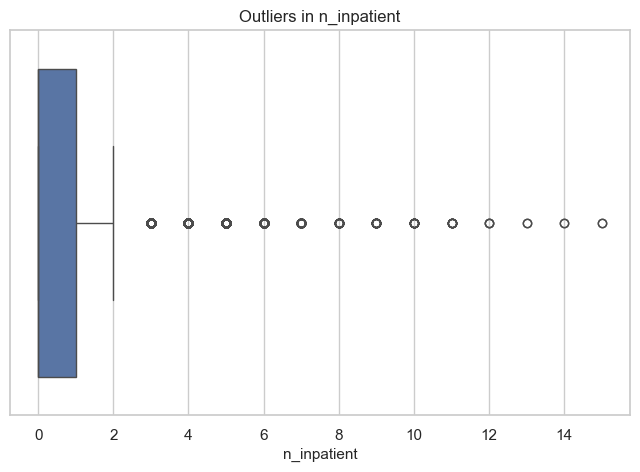

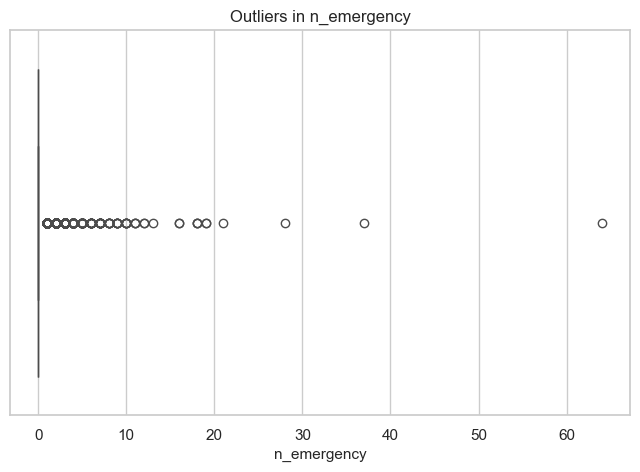

In [40]:
for col in numerical_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Outliers in {col}')
    plt.show()


Outliers were primarily observed in utilization and treatment intensity variables, reflecting a small subset of clinically complex, high-risk patients rather than data quality issues.

**Summary of Exploratory Data Analysis:**

The exploratory analysis identified patient and utilization patterns that are closely aligned with known drivers of avoidable hospital readmissions, including advanced age, prior inpatient utilization, length of stay, and medication burden. The relatively balanced readmission outcome, combined with clinically interpretable features, provides a strong foundation for predictive modeling within a value-based care framework. Building on these insights, the modeling phase applies supervised machine learning techniques to stratify readmission risk, support proactive care management, and inform population-level interventions aimed at improving outcomes, reducing unnecessary utilization, and mitigating readmission-related penalties.

## 5. Data Cleaning and Preprocessing

Before modeling, we must ensure the data is clean and in a suitable format.

Steps:

- Checking and handling missing values  
- Standardize column names  
- Encoding target variable


We saw that there are no blank or null values in the dataset in **4.1 Missing Values Analysis** section.

In [41]:
# Get a copy of the dataset to work with
df_model = df.copy()

# Standardize column names
df_model.columns = df_model.columns.str.lower().str.strip()

# Convert target to binary
df_model['readmitted'] = df_model['readmitted'].map({
    'no': 0,
    'yes': 1
})

#Check for any remaining nulls

df_model.isnull().sum().sort_values(ascending=False).head()


age             0
diag_1          0
diabetes_med    0
change          0
a1ctest         0
dtype: int64

## 6. Feature Engineering



In [42]:
# Convert age categories to ordinal values
age_mapping = {
    '[0-10)': 0, '[10-20)': 1, '[20-30)': 2,
    '[30-40)': 3, '[40-50)': 4, '[50-60)': 5,
    '[60-70)': 6, '[70-80)': 7, '[80-90)': 8,
    '[90-100)': 9
}

df_model['age_group'] = df_model['age'].map(age_mapping)


In [43]:
# Create total prior visits feature
df_model['total_prior_visits'] = (
    df_model['n_outpatient'] +
    df_model['n_emergency'] +
    df_model['n_inpatient']
)

In [44]:
# Create high utilizer flag
df_model['high_utilizer'] = np.where(
    df_model['total_prior_visits'] >= 3, 1, 0
)

In [45]:
# Drop original age column (if using encoded version)
df_model.drop(columns=['age'], inplace=True)

In [46]:
# Define Features and Target

X = df_model.drop('readmitted', axis=1)
y = df_model['readmitted']

In [47]:
# Preprocessing Pipeline

# Separate numerical and categorical features
numerical_cols = X.select_dtypes(include=['int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

## 7. Modeling

### 7.1 Baseline Logistic Regression Model with L2 regularization

In [48]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))  #L2 regularization used by default
])


In [49]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

In [50]:
# Train model
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

## 8. Model Evaluation

### 8.1 Baseline model evaluation

To evaluate the model, we focus on measures that reflect its ability to correctly identify patients at risk of being readmitted. In a healthcare setting, missing a high-risk patient can result in preventable complications, higher costs, and potential penalties under value-based care programs. For that reason, we pay close attention to how well the model detects patients who are likely to return to the hospital, rather than looking at overall accuracy alone.

We also use a metric that evaluates how well the model separates higher-risk patients from lower-risk patients across different risk thresholds. This is important because healthcare organizations may adjust intervention thresholds depending on available care management resources. Together, these measures provide a practical view of how the model would perform in real-world population health management.

In [51]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.78      0.68      2649
           1       0.63      0.42      0.50      2351

    accuracy                           0.61      5000
   macro avg       0.62      0.60      0.59      5000
weighted avg       0.61      0.61      0.60      5000

Confusion Matrix:

[[2062  587]
 [1360  991]]
ROC-AUC Score: 0.6445285083863497


### 8.2 Baseline model interpretation

Legend: 0 - Non-readmission, 1 - Readmission

The model seems to be good at predicting non-readmissions (recall for class 0 - 78%) but weak at identifying readmissions (recall for class 1 - 42%). The model misses 1,360 high-risk patients. This is concerning in value-based care setting.

When the model predicts readmission, it's correct 63% of the time. It only captures 42% of actual readmission. An f1-score of 0.50 indicates moderate but limited effectiveness.

Overall Performance:

**Accuracy: 61%**

**ROC-AUC: ~0.645**

The model performs better than random (0.50). AUC of 0.64 indicates moderate discrimination, but not strong predictive power.

**Summary:**

The model is better at identifying low-risk patients than high-risk ones.
It would reduce unnecessary interventions, but it would fail to identify a large proportion of patients who may benefit from care management.

As a baseline model, this is acceptable, but there is room for improvement.